In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vincenty import vincenty

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
import pickle

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10000)

In [4]:
#Import natural disaster data
raw = pd.read_csv('natural_disaster_human_mobility.csv')

In [5]:
#Switch latitude and longtitude columns, rename and reorder, dataframe
df = raw
df = df.rename(columns = {'disaster.event': 'event', 'user.anon': 'user', 'latitude': 'long', 'longitude.anon': 'lat'})
df = df[['event', 'user', 'lat', 'long', 'time']]
df['time'] = pd.DatetimeIndex(df['time'])

In [6]:
#Clean event names
event_name={
'01_Wipha':'Wipha',
'02_Halong': 'Halong',
'06_Kalmaegi': 'Kalmaegi',
'08_Rammasun_Manila': 'Manila',
'12_Bohol': 'Bohol',
'13_Iquique': 'Iquidue',
'14_Napa': 'Napa',
'21_Norfolk': 'Norfolk',
'22_Hamburg': 'Hamburg',
'23_Atlanta': 'Atlanta',
'31_Phoenix': 'Phoenix',
'32_Detroit': 'Detroit',
'33_Baltimore': 'Baltimore',
'41_AuFire1': 'Australia1',
'42_AuFire2': 'Australia2'}

df['event_name'] = df['event'].map(event_name)

In [7]:
#Add event type
event_type={
'Wipha': 'Typhoon',
'Halong': 'Typhoon',
'Kalmaegi': 'Typhoon',
'Manila': 'Typhoon',
'Bohol': 'Earthquake',
'Iquidue': 'Earthquake',
'Napa': 'Earthquake',
'Norfolk': 'Winter_Storm',
'Hamburg': 'Winter_Storm',
'Atlanta': 'Winter_Storm',
'Phoenix': 'Thunderstorm',
'Detroit': 'Thunderstorm',
'Baltimore': 'Thunderstorm',
'Australia1': 'Wildfire',
'Australia2': 'Wildfire'}    

df['event_type'] = df['event_name'].map(event_type)
df = df.drop(columns = ['event'])

In [8]:
df.groupby('event_name').count()

,user,lat,long,time,event_type
event_name,,,,,
Atlanta,157178,157178,157178,157178,157178
Australia1,43275,43275,43275,43275,43275
Australia2,64370,64370,64370,64370,64370
Baltimore,328880,328880,328880,328880,328880
Bohol,114606,114606,114606,114606,114606
Detroit,765349,765349,765349,765349,765349
Halong,171559,171559,171559,171559,171559
Hamburg,15053,15053,15053,15053,15053
Iquidue,15297,15297,15297,15297,15297


In [9]:
#Remove Wipia, has bad data 300,000 enteries!
df = df.loc[df['event_name'] != 'Wipha']

In [10]:
#Add date column, drop time column
df['date'] = df['time'].dt.date
df['date'] = pd.to_datetime(df['date'])

In [76]:
#Disaster day function and key
def disaster_day(event_name, date):
    if event_name == 'Wipha' and str(date) == '2013-10-11 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-12 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-13 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-14 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-15 00:00:00':
        return True    
    elif event_name == 'Wipha' and str(date) == '2013-10-16 00:00:00':
        return True    
    elif event_name == 'Manila' and str(date) == '2014-07-11 00:00:00':
        return True    
    elif event_name == 'Manila' and str(date) == '2014-07-12 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-13 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-14 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-15 00:00:00':
        return True      
    elif event_name == 'Manila' and str(date) == '2014-07-16 00:00:00':
        return True    
    elif event_name == 'Manila' and str(date) == '2014-07-17 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-18 00:00:00':
        return True  
    elif event_name == 'Bohol' and str(date) == '2013-10-15 00:00:00':
        return True 
    elif event_name == 'Iquidue' and str(date) == '2014-04-01 00:00:00':
        return True     
    elif event_name == 'Napa' and str(date) == '2014-08-24 00:00:00':
        return True   
    elif event_name == 'Atlanta' and str(date) == '2014-01-08 00:00:00':
        return True   
    elif event_name == 'Detroit' and str(date) == '2014-09-20 00:00:00':
        return True   
    elif event_name == 'Australia1' and str(date) >= '2013-10-17 00:00:00':
        return True
    else:
        return False

In [77]:
def wizzard(data):
    #Apply disaster day fucntion
    data['disaster_day'] = data.apply(lambda row: disaster_day((row['event_name']), (row['date'])), axis = 1)
    
    #Create diststance from center column
    data['dist_cent'] = data.apply(lambda row: vincenty((row['lat'], row['long']), \
                                    (data['lat'].mean(),  data['long'].mean())), axis=1) 
    
    #Sort data by time
    data = data.groupby(['event_name', 'user'], group_keys=False)
    data = data.apply(lambda _data: _data.sort_values(by=['time']))
    
    #Generate distance between tweets column
    data['lat_1'] = data['lat'].shift()
    data['long_1'] = data['long'].shift()
    data['dist_mi'] = data.apply(lambda row: vincenty((row['lat'], row['long']), (row['lat_1'], row['long_1'])), axis=1)

    #Create tweet velocity column
    data['time_diff'] = data['time'].diff()
    data['time_diff_hour'] = data['time_diff']/np.timedelta64(1, 'h')
    data['time_diff_day'] = data['time_diff']/np.timedelta64(1, 'D')
    data['velocity_mph'] = data['dist_mi']/data['time_diff_hour']
    #data['velocity_mph'] = data.loc[data['velocity_mph'] != 0]
    #data['velocity_mph'] = data['velocity_mph'].astype(float)
    #data['dist_cent'] = data.apply(lambda row: vincenty((row['lat'], row['long']), \
                                    #(data['lat'].mean(),  data['long'].mean())), axis=1)    
    
    #Delete first row in every groupby
    data = data.groupby(['event_name', 'user'], group_keys=False).apply(lambda row: row.iloc[1:])
    
    #Turn infiniti values into NaNs and drop NaNs
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    
    return data

In [54]:
napa = df.loc[df['event_name'] == 'Napa']
napa = wizzard(napa)

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [23]:
#napa.groupby(['user']).mean()

In [60]:
napa_2 = napa.loc[napa['velocity_mph'] <80]
napa_2 = napa_2.groupby(['event_name', 'disaster_day','date'], group_keys=False).mean()
napa_2

user        lat        long  \
event_name disaster_day date                                             
Napa       False        2014-07-30   807.364030  34.444147 -122.304541   
                        2014-07-31   891.236295  34.442300 -122.302053   
                        2014-08-01   864.902235  34.444387 -122.303938   
                        2014-08-02   905.153598  34.443500 -122.303692   
                        2014-08-03   793.192432  34.444677 -122.303778   
                        2014-08-04   866.093701  34.444793 -122.305780   
                        2014-08-05   863.607740  34.442273 -122.302785   
                        2014-08-06   889.192668  34.444912 -122.304628   
                        2014-08-07   775.947917  34.443022 -122.304212   
                        2014-08-08   738.546483  34.443248 -122.303837   
                        2014-08-09   819.431976  34.443703 -122.304282   
                        2014-08-10   798.417925  34.445602 -122.303466   
                        2014-08-11   879.372208  34.443209 -122.301281   
                        2014-08-12   931.508197  34.442387 -122.297410   
                        2014-08-13   856.131016  34.442671 -122.301001   
                        2014-08-14   890.717557  34.445067 -122.301242   
                        2014-08-15   897.390173  34.444313 -122.301465   
                        2014-08-16   817.243105  34.441932 -122.303518   
                        2014-08-17   905.315680  34.443240 -122.303273   
                        2014-08-18   854.399390  34.442425 -122.301615   
                        2014-08-19   882.964066  34.444072 -122.301029   
                        2014-08-20   940.964082  34.444106 -122.304052   
                        2014-08-21   893.455210  34.445741 -122.302585   
                        2014-08-22   951.287815  34.440833 -122.301465   
                        2014-08-23  1036.031136  34.442638 -122.302216   
                        2014-08-25   897.127148  34.438992 -122.302703   
                        2014-08-26   913.039168  34.437811 -122.302223   
                        2014-08-27   933.933160  34.442945 -122.304464   
                        2014-08-28   926.295762  34.435829 -122.298282   
                        2014-08-29   980.074737  34.442095 -122.301295   
                        2014-08-30  1049.454545  34.446636 -122.300050   
           True         2014-08-24   969.373752  34.439419 -122.301637   

                                    dist_cent      lat_1      long_1  \
event_name disaster_day date                                           
Napa       False        2014-07-30   2.022782  34.444031 -122.304693   
                        2014-07-31   2.563582  34.442492 -122.301930   
                        2014-08-01   2.523571  34.444443 -122.304025   
                        2014-08-02   2.521736  34.443143 -122.303641   
                        2014-08-03   2.381890  34.444689 -122.303586   
                        2014-08-04   2.290570  34.444786 -122.305898   
                        2014-08-05   2.432994  34.442281 -122.303166   
                        2014-08-06   1.992327  34.444605 -122.304407   
                        2014-08-07   2.470665  34.443075 -122.304364   
                        2014-08-08   2.320489  34.443391 -122.303962   
                        2014-08-09   2.473020  34.443613 -122.304418   
                        2014-08-10   2.326681  34.445716 -122.303344   
                        2014-08-11   2.167767  34.442899 -122.301490   
                        2014-08-12   2.424141  34.442413 -122.297311   
                        2014-08-13   2.321812  34.442687 -122.300962   
                        2014-08-14   2.502157  34.445305 -122.301283   
                        2014-08-15   2.374353  34.444072 -122.301607   
                        2014-08-16   2.662872  34.442273 -122.303858   
                        2014-08-17   2.550083  34.442725 -122.302788   
              

In [70]:
vincenty((napa_2.iloc[0,1], napa_2.iloc[0,2]), (napa_2['lat'].mean(), (napa_2['long'].mean())))

0.233278

In [71]:
napa_2['dist_cent2'] = napa_2.apply(lambda row: vincenty((row['lat'], row['long']), \
                                    (napa_2['lat'].mean(),  napa_2['long'].mean())), axis=1) 

In [ ]:
vincenty((Aus1_2.iloc[0,3], Aus1_2.iloc[0,4]), (Aus1_2['lat'].mean(), (Aus1_2['long'].mean())))

In [19]:
#Bohol = df.loc[df['event_name'] == 'Bohol']
#Bohol = wizzard(Bohol)

In [ ]:
Bohol = Bohol.loc[Bohol['velocity_mph'] <80]
Bohol.groupby(['event_name', 'disaster_day']).mean()

In [ ]:
Iquidue = df.loc[df['event_name'] == 'Iquidue']
Iquidue = wizzard(Iquidue)

In [ ]:
Iquidue_2 = Iquidue.loc[Iquidue['velocity_mph'] <80]
Iquidue_2.groupby(['event_name', 'disaster_day']).mean()

In [137]:
Aus1 = df.loc[df['event_name'] == 'Australia1']
Aus1 = wizzard(Aus1)

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [248]:
Aus5 = Aus1
Aus5['tweets'] = Aus5.groupby(['event_name', 'disaster_day','date']).cumcount()
Aus5 = Aus5.groupby(['event_name', 'disaster_day', 'date']).agg({'velocity_mph': ['mean'],\
                                                          'dist_cent2' : ['mean'],\
                                                          'dist_mi' : ['mean'],\
                                                          'time_diff_day' : ['mean'],\
                                                          'lat' : ['mean'],\
                                                          'long' : ['mean'],\
                                                          'tweets' : ['max']})
Aus5 = Aus5.reset_index()
Aus5.columns = list(Aus5.columns.levels[0][-3:][::-1]) + list(Aus5.columns.levels[0][:-3])

Aus5['dist_cent3'] = Aus5.apply(lambda row: vincenty((row['lat'], row['long']), \
                                    (Aus5['lat'].mean(),  Aus5['long'].mean())), axis=1) 

Aus5

,event_name,disaster_day,date,velocity_mph,dist_cent2,dist_mi,time_diff_day,lat,long,tweets,dist_cent3
0,Australia1,False,2013-10-08,1.437664,29.370764,0.620010,0.048037,-22.528696,151.066157,756,1.767804
1,Australia1,False,2013-10-09,1.910824,29.140729,1.261132,0.178752,-22.517076,151.089385,935,3.155557
2,Australia1,False,2013-10-10,3.294205,29.943013,1.761015,0.232544,-22.511488,151.106617,1254,4.705334
3,Australia1,False,2013-10-11,2.300746,28.691807,1.695762,0.370989,-22.536021,151.069364,1035,0.914929
4,Australia1,False,2013-10-12,2.447503,29.499513,2.330233,0.349338,-22.515683,151.124475,1121,5.870295
5,Australia1,False,2013-10-13,0.866418,27.858586,1.313500,0.454933,-22.533218,151.090781,1084,1.898548
6,Australia1,False,2013-10-14,1.759279,27.726057,1.715860,0.607726,-22.531524,151.090522,903,1.983090
7,Australia1,False,2013-10-15,1.908121,25.879732,1.761694,0.541176,-22.538965,151.089576,989,1.531152
8,Australia1,False,2013-10-16,3.085875,28.402202,1.953595,0.604534,-22.539275,151.035802,956,4.059744
9,Australia1,True,2013-10-17,2.695647,29.146502,1.897900,0.606623,-22.536754,151.055968,1371,2.065196


In [ ]:
sns.lineplot

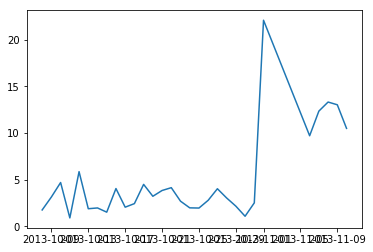

In [249]:
plt.plot(Aus5['date'], Aus5['dist_cent3'])

In [ ]:
fire = []
for i in range(30):
    fire.append((vincenty((Aus1_2.iloc[i,3], Aus1_2.iloc[i,4]), (ave_lat, ave_long))))
    fire

In [ ]:
fire2 = []
for i in range(30):
    fire2.append((vincenty((Aus1_2.iloc[i,3], Aus1_2.iloc[i,4]), (-22.5592, 151.071))))
    fire2

In [ ]:
Aus1.mean()

In [ ]:
fire_date

In [ ]:
len(fire)

In [ ]:
fire_date= pd.date_range(start='2013-10-08', end='2013-17-10')

fire_dist = pd.DataFrame(fire_date, fire)

In [ ]:
fire2

In [ ]:
#Stating at 9, 10/17


In [ ]:
vincenty((Aus1_2.iloc[0,3], Aus1_2.iloc[0,4]), (ave_lat, ave_long))

In [ ]:
Aus1_3 = Aus1.loc[Aus1['date'] <= '2013-10-16 00:00:00']
ave_lat = Aus1_3['lat'].mean()
ave_lat = -22.527398642433642

In [ ]:
ave_long = Aus1_3['long'].mean()
ave_long = 151.0865233766378

In [ ]:
aus_fire = Aus1_2.iloc[:,1]
#aus_fire.info()
#vincenty((aus1_2.iloc[0,1], aus1_2.iloc[1,1]), (ave_lat, ave_long))

#aus_fire['dist_fire'] = aus_fire.apply(lambda row: vincenty((row['lat'], row['long']), \
                                                    #(ave_lat, ave_long), axis=1))

In [ ]:
#aus_fire['fire_dist'] = aus_fire.apply(lambda row: vincenty((row['lat'], row['long']), \
                                                    #(ave_lat, ave_long), axis=1))
aus_fire

In [ ]:
napa_3 = napa.groupby(['event_name', 'date']).mean().unstack()

In [ ]:
Aus1_2.shape

In [ ]:
napa_2.to_csv('napa_22.csv')

In [ ]:
Aus1_2.to_csv('Aus1.csv')

In [ ]:
sns.scatterplot(x=napa_2['lat'], y=napa_2['long'], hue=napa_2['disaster_day'])

In [ ]:
#sns.scatterplot(x=napa_2['lat'], y=napa_2['long'], hue=napa_2['time'])

In [ ]:
X = np.append(napa_group3['lat'],napa_group3['long']).transpose()

In [ ]:
X = Aus1_2[['lat', 'long']]

In [ ]:
X = X.as_matrix()

In [ ]:
X.shape

In [ ]:
#helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [ ]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X)
display_cluster(X,km,num_clusters)

In [ ]:
km.cluster_centers_

In [ ]:
km.inertia_

In [ ]:
plt.plot([KMeans(n_clusters=i).fit(X).inertia_ for i in range(1,10)])

In [ ]:
#Pickle data
redo_pickle = False
if redo_pickle == True:
    with open('df.pickle','wb') as f:
        pickle.dump(df,f)
#if redo_pickle == False:
    #with open('df.pickle','rb') as f:
        #df = pickle.load(f)

In [ ]:
#Add natural disaster tag
'Wipha' and '2013-10-11', '2013-10-12', '2013-10-13', '2013-10-14', '2013-10-15', '2013-10-16'
#'Halong'
#'Kalmaegi'
'Manila' and '2014-7-11', '2014-7-12', '2014-7-13', '2014-7-14', '2014-7-15', '2014-7-16', '2014-7-17', '2014-7-18'
'Bohol' and '2013-10-15'
'Iquidue'and '2014-04-01'
'Napa' and '2014-08-24
'Norfolk'
'Hamburg'
'Atlanta' '2014-01-28'
'Phoenix': 
'Detroit': '2014-09-20'
'Baltimore': 
'Australia1': 2013-10-17, 2013-10-28
'Australia2': 

    

In [ ]:
#Sort data by time
df_small = df_small.groupby(['event_name', 'user'], group_keys=False)
df_small = df_small.apply(lambda _df_small: _df_small.sort_values(by=['time']))

In [ ]:
#Generate distance between tweets column
df_small['lat_1'] = df_small['lat'].shift()
df_small['long_1'] = df_small['long'].shift()
df_small['dist_mi'] = df_small.apply(lambda row: vincenty((row['lat'], row['long']), (row['lat_1'], row['long_1'])), axis=1)

In [ ]:
#Delete first row in every groupby
df_small = df_small.groupby(['event_name', 'user'], group_keys=False).apply(lambda row: row.iloc[1:])

In [ ]:
#Create tweet velocity column
df_small['time_diff'] = df_small['time'].diff()
df_small['time_diff_hour'] = df_small['time_diff']/np.timedelta64(1, 'h')
df_small['time_diff_day'] = df_small['time_diff']/np.timedelta64(1, 'D')
df_small['velocity_mph'] = df_small['dist_mi']/df_small['time_diff_hour']
df_small['dist_cent'] = df_small.apply(lambda row: vincenty((row['lat'], row['long']), \
                                                    (df_small['lat'].mean(), df_small['long'].mean())), axis=1)

In [ ]:
        return True 
    elif event_name == 'Australia1' and str(date) == '2013-10-18 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-19 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-20 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-21 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-10-22 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-23 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-24 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-25 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-26 00:00:00':
        return True 
    elif event_name == 'Australia1' and str(date) == '2013-10-27 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-28 00:00:00':
        return True
    elif event_name == 'Australia1' and str(date) == '2013-10-29 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-10-30 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-10-31 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-01 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-02 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-03 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-04 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-05 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-06 00:00:00':
        return True      
    elif event_name == 'Australia1' and str(date) == '2013-11-07 00:00:00':
        return True      
    elif event_name == 'Australia1' and str(date) == '2013-11-05 00:00:00':
        return True      
    elif event_name == 'Australia1' and str(date) == '2013-11-05 00:00:00':
        return True      
    elif event_name == 'Australia1' and str(date) == '2013-11-05 00:00:00':
        return True 